Can conv nets be used to detect patterns in trajectories?

Let's train CNN on the data, where each channel represents a feature, one row represents and observation and number of columns in that row coressponds to the number of timesteps.

In [1]:
import os
import sys

# Append utils as a module
module_path = os.path.abspath(os.path.join('utils/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import numpy.ma as ma
np.random.seed(42)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras import backend as K
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

from plot_helpers import plot_confusion_matrix, plot_path
from helpers import traject_to_coord, slice_gen
from data_preprocessing import denorm, norm_values
from keras_helpers import *

Using TensorFlow backend.


# Prepare data for being processed in conv nets

In [2]:
df = pd.read_csv('demo_data/data.csv')
print(df.shape)
df.head()

(96870, 9)


,x,y,time,user,task,move_dir,move_dir_norm,move_len,move_len_norm
0,0.38849,0.02145,0.20605,0,wiki,0.000000,0.000000,0.000000,0.000000
1,0.38830,0.04004,0.23047,0,wiki,3.151818,0.501627,0.018591,0.012910
2,0.38614,0.04428,0.26855,0,wiki,3.612759,0.574989,0.004758,0.003305
3,0.38749,0.04990,0.34180,0,wiki,2.905845,0.462480,0.005780,0.004014
4,0.38321,0.12272,0.37012,0,wiki,3.200300,0.509344,0.072946,0.050657


In [3]:
TIMESTEPS = 60                                 # length of sequence on which we train
step = 10                                      # step to take next slice (if step = timesteps seqs won't overlay)
features = ['move_dir_norm', 'move_len_norm']  # features to train on

### Time slices

In [4]:
# Convert task labels to integers
df['task_cat'] = df.task.astype('category').cat.codes
codes = dict(enumerate(df.task.astype('category').cat.categories))
x_d = df[features].values
y_d = df['task_cat'].values

y_labels = slice_gen(y_d, TIMESTEPS, step=step, only_full=True)
# drop those sequences where label is ambiguous (on junction between tasks)
y_not_mixed = [True if len(set(i)) == 1 else False for i in list(y_labels)]

# split into seqs of length N 
x_gen = list(slice_gen(x_d, TIMESTEPS, step=step, only_full=True))
y_gen = list(slice_gen(y_d, TIMESTEPS, step=step, only_full=True))
y_gen = [i[0] for i in y_gen]

x_data = np.array(x_gen)
y_data = np.array(y_gen)

x_data = x_data[y_not_mixed]
y_data = y_data[y_not_mixed]

print('x_data shape', x_data.shape)
print('y_data shape', y_data.shape)

print('\nCodes for categories:')
print(codes)

x_data shape (9634, 60, 2)
y_data shape (9634,)

Codes for categories:
{0: 'news', 1: 'pinterest', 2: 'search', 3: 'vk', 4: 'wiki', 5: 'youtube'}


### One-hot encoding and train-test sets

In [5]:
# Data dimensions:
# (observations, timesteps, channels (features))

# Fit the label encoder to our label series
encoder = LabelBinarizer()
y_data_hot = encoder.fit_transform(y_data)

# shuffle the data 
idxs = np.arange(len(x_data))
np.random.shuffle(idxs)
x_data = x_data[idxs]
y_data_hot = y_data_hot[idxs]

# expand dimensions in X data to make it: [N obs, 1 (rows), N timesteps (columns), N features (channels)]
# x_data = np.expand_dims(x_data, 1)
# Con1D input dimensions (batchSize, length, channels)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data_hot, test_size=0.1, random_state=42)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print()
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print()

# compute class probability and set higher weight to rare classes to deal with unbalanced data
sample_weights = compute_sample_weight('balanced', y_train)
print("Classes weights and # of observations:")
for i in zip(*np.unique(sample_weights, return_counts=True)):
    print("\tobs. {},\b weigth: {:.2f}".format(i[1], i[0]))
print()
    
NUM_CLASSES = len(np.unique(y_data, axis=0))
TIMESTEPS = x_data.shape[1]
print("Number of classes:", NUM_CLASSES)
print("Timesteps per observation:", TIMESTEPS)

x_train shape: (8670, 60, 2)
y_train shape: (8670, 6)

8670 train samples
964 test samples

Classes weights and # of observations:
	obs. 2226, weigth: 0.14
	obs. 1813, weigth: 0.18
	obs. 1613, weigth: 0.21
	obs. 1095, weigth: 0.33
	obs. 1075, weigth: 0.33
	obs. 848, weigth: 0.44

Number of classes: 6
Timesteps per observation: 60


# Create and train a model

### Specify model

In [6]:
# To convolve through features (represented as channels here) we use 1D conv layers
# Kernel size determines how much data each filter sees
# Conv1D input dimensions (batchSize, length, channels)

input_shape = x_data.shape[1:]

model = Sequential()
model.add(Conv1D(32, kernel_size=3,
                 activation='relu',
                 input_shape=input_shape, 
                 padding='same',
                 name='conv1', 
                 strides=1))
model.add(MaxPooling1D(pool_size=2, name='pool1'))
model.add(BatchNormalization(name='batch1'))
model.add(Dropout(0.25, name='dropout1'))

model.add(Conv1D(64, 3, activation='relu', padding='same', name='conv2'))
model.add(MaxPooling1D(pool_size=2, name='pool2'))
model.add(BatchNormalization(name='batch2'))
model.add(Dropout(0.25, name='dropout2'))

model.add(Conv1D(128, 3, activation='relu', padding='same', name='conv3'))
model.add(MaxPooling1D(pool_size=2, name='pool3'))
model.add(Flatten(name='flatten1'))
model.add(Dropout(0.25, name='dropout3'))

model.add(BatchNormalization(name='batch3'))
model.add(Dropout(0.4, name='dropout4'))

model.add(Dense(128, activation='sigmoid', name='fc1'))
model.add(Dropout(0.4, name='dropout5'))

model.add(Dense(NUM_CLASSES, activation='softmax', name='fc2'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 60, 32)            224       
_________________________________________________________________
pool1 (MaxPooling1D)         (None, 30, 32)            0         
_________________________________________________________________
batch1 (BatchNormalization)  (None, 30, 32)            128       
_________________________________________________________________
dropout1 (Dropout)           (None, 30, 32)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 30, 64)            6208      
_________________________________________________________________
pool2 (MaxPooling1D)         (None, 15, 64)            0         
_________________________________________________________________
batch2 (BatchNormalization)  (None, 15, 64)            256       
__________

### Train the model

In [7]:
batch_size = 1024
epochs = 100
MODEL_PATH = 'demo_data/conv1d_model.h5'

# stop training if val accuracy doesn't improve
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          min_delta=0, patience=50, verbose=0, mode='auto')
# save a model with the highest val acc score
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_acc', verbose=0, 
                                             save_best_only=True, mode='max')

callbacks = [checkpoint]#, earlystop]

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          sample_weight=sample_weights,
          callbacks=callbacks)

score = model.evaluate(x_test, y_test, verbose=2)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 8670 samples, validate on 964 samples
Epoch 1/100
8670/8670 [==============================] - 2s 217us/step - loss: 0.4919 - acc: 0.1429 - val_loss: 1.9084 - val_acc: 0.0851
Epoch 2/100
8670/8670 [==============================] - 1s 78us/step - loss: 0.4469 - acc: 0.2261 - val_loss: 1.7582 - val_acc: 0.2624
Epoch 3/100
8670/8670 [==============================] - 1s 68us/step - loss: 0.4365 - acc: 0.2464 - val_loss: 1.7669 - val_acc: 0.2624
Epoch 4/100
8670/8670 [==============================] - 1s 68us/step - loss: 0.4305 - acc: 0.2419 - val_loss: 1.8139 - val_acc: 0.0851
Epoch 5/100
8670/8670 [==============================] - 1s 68us/step - loss: 0.4217 - acc: 0.2459 - val_loss: 1.8347 - val_acc: 0.0851
Epoch 6/100
8670/8670 [==============================] - 1s 67us/step - loss: 0.4153 - acc: 0.2562 - val_loss: 1.8372 - val_acc: 0.0851
Epoch 7/100
8670/8670 [==============================] - 1s 67us/step - loss: 0.4115 - acc: 0.2660 - val_loss: 1.8391 - val_acc: 0.2002


8670/8670 [==============================] - 1s 70us/step - loss: 0.3090 - acc: 0.4642 - val_loss: 1.5790 - val_acc: 0.3081
Epoch 61/100
8670/8670 [==============================] - 1s 67us/step - loss: 0.3079 - acc: 0.4602 - val_loss: 1.6123 - val_acc: 0.2956
Epoch 62/100
8670/8670 [==============================] - 1s 68us/step - loss: 0.3053 - acc: 0.4604 - val_loss: 1.6012 - val_acc: 0.2998
Epoch 63/100
8670/8670 [==============================] - 1s 68us/step - loss: 0.3053 - acc: 0.4681 - val_loss: 1.5793 - val_acc: 0.3071
Epoch 64/100
8670/8670 [==============================] - 1s 68us/step - loss: 0.3039 - acc: 0.4698 - val_loss: 1.5847 - val_acc: 0.3008
Epoch 65/100
8670/8670 [==============================] - 1s 70us/step - loss: 0.3007 - acc: 0.4768 - val_loss: 1.5239 - val_acc: 0.3257
Epoch 66/100
8670/8670 [==============================] - 1s 70us/step - loss: 0.3024 - acc: 0.4622 - val_loss: 1.4840 - val_acc: 0.3527
Epoch 67/100
8670/8670 [==============================

In [8]:
model = load_model(MODEL_PATH)

### Check the model's performance

In [9]:
pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1)
score = model.evaluate(x_test, y_test, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1813198145
Test accuracy: 0.544605809129


             precision    recall  f1-score   support

     search       0.56      0.62      0.59       170
         vk       0.66      0.57      0.61       136
       wiki       0.31      0.79      0.44        82
       news       0.54      0.38      0.45       117
       maps       0.64      0.41      0.50       206
    youtube       0.64      0.58      0.61       253

avg / total       0.59      0.54      0.55       964



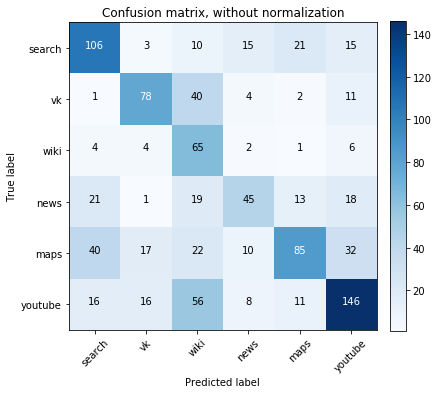

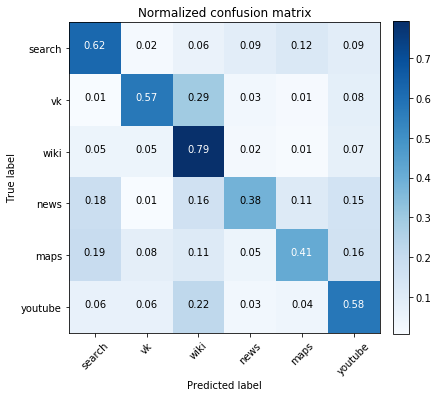

In [10]:
# Confusion Matrix
target_names = ['search', 'vk', 'wiki', 'news', 'maps', 'youtube']
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))


# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

p = plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
p = plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Visualize filters

In [11]:
# model layers
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict.keys()

dict_keys(['flatten1', 'batch1', 'batch3', 'fc1', 'pool3', 'conv3', 'dropout5', 'dropout1', 'conv2', 'dropout3', 'batch2', 'fc2', 'conv1', 'pool2', 'pool1', 'dropout4', 'dropout2'])

## Get activations

To make the operation compatible, we will arrange our filter to 1x9. Now, if we do a matrix multiplication over our stretched image and filter, we will have 1x100 image as a result, which we could reshape it back to 10x10 or 1x1x10x10 image.

In [12]:
def convolve_1d(string, kernel, padding=False, step=1):
    """Convolve 1d vector with the kernel"""
    
    k_s = len(kernel)
    # kernel = np.flip(kernel, axis=0)      # Flip the kernel
    
    if padding:
        # Add zero padding to the input 
        string_padded = np.zeros(string.shape[0] + 2)   
        string_padded[1:-1] = string
    else:
        string_padded = string
    
    output = [] # convolution output
        
    # Loop over every value of the input
    for x in range(0, string_padded.shape[0] - k_s + 1, step):    
        # element-wise multiplication of the kernel and the input
        out = (kernel * string_padded[x : x + k_s]).sum() 
        output.append(out)
    output = np.asarray(output)
    
    return output


def convolve_1d_channels(string_ch, kernel, padding=False, step=1):
    """Convolve 2d array (values, channels) with the kernel.
    Return output (activations, channels)"""
    output = []
    for i in range(string_ch.shape[1]):
        ch_out = convolve_1d(string_ch[..., i], kernel[..., i], padding=padding, step=step)
        output.append(ch_out)
    output = np.vstack(output).T
    
    return output

In [13]:
def plot_conv1_filter(model, fn, n_obs=10000, top_n=20, percentile=95, show_percentile=False):
    
    f = get_filter_weights(model, fn, layer='conv1')
    filter_size = f.shape[0]

    np.random.seed(42)
    paths = np.random.rand(n_obs*filter_size, 2)  

    # find trajectories for the data
    move_dir = denorm(paths[..., 0], x_max=np.pi*2).reshape(n_obs, filter_size)
    move_len = denorm(paths[..., 1], x_max=1/3).reshape(n_obs, filter_size)
    xy = [traject_to_coord(move_dir[i], move_len[i], 0.5, 0.5) for i in range(n_obs)]
    xy = np.asarray(xy).reshape(n_obs*(filter_size+1), 2)

    # convert to segments and drop unwanted connections (every 4th segment)
    segments = np.array(list(zip(xy[:-1], xy[1:])))
    idx_delete = np.arange(filter_size, n_obs*(filter_size+1)-1, filter_size+1)
    segments = np.delete(segments, idx_delete, axis=0)

    # filer activation
    acts = np.sum(convolve_1d_channels(paths, f, padding=False, step=filter_size), axis=1)
    if show_percentile:
        tr = np.percentile(acts, 95)
    else:
        tr = np.sort(acts)[::-1][top_n]
    
    print("Filter:\n", f)
    print("Activation threshold: {:.2f}".format(tr))
    
    # expand activations to segments size and filter segm by threshold
    weights = np.repeat(acts, filter_size)
    segments = segments[weights > tr]
    weights = weights[weights > tr]

    ## plot heatmap 
    fig1, ax = plt.subplots(1, 3, figsize=(12, 4))

    for i in range(filter_size):
        dir_1_idx = np.arange(i, segments.shape[0], filter_size)
        dir_1_xy = segments[dir_1_idx][:, 1]
        dir_1_xy =  np.vstack([dir_1_xy, [0, 0], [1, 1]]) # add corner values

        heatmap, xedges, yedges = np.histogram2d(dir_1_xy[:, 0], dir_1_xy[:, 1], bins=100)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        ax[i].imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis')
        ax[i].plot(0.5, 0.5, marker='+', markersize=10, color='orange', linestyle='None')
        ax[i].invert_yaxis()
        ax[i].set_title("{} segment".format(i+1))
    plt.suptitle("Direction heatmap for segments in top {} trajectories".format(len(weights)/filter_size), y=1.04)
    plt.tight_layout()

    segments = segments[weights > tr]
    weights = weights[weights > tr]

    ## plot top trajectories which activate filter
    
    fig2 = plot_path(segments, segments_weights=weights, figsize=(12, 8), show_joints=True, screen_lims=False,
                  change_width=False, clip=False, feed_lines=True, alpha=0.75)
    
    return fig1, fig2

conv1 (964, 60, 32)


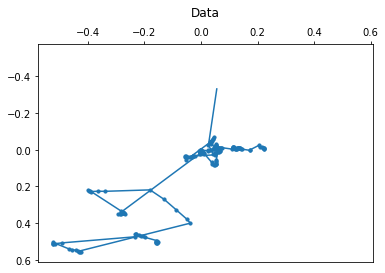

FILTER # 0
Filter:
 [[ 0.11  0.17]
 [-0.16  0.17]
 [ 0.16  0.3 ]]
Activation threshold: 0.59


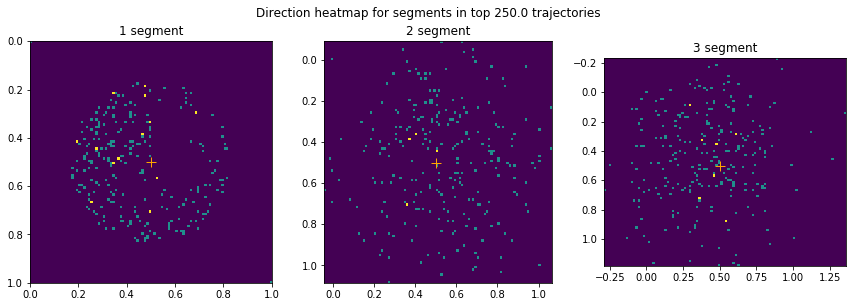

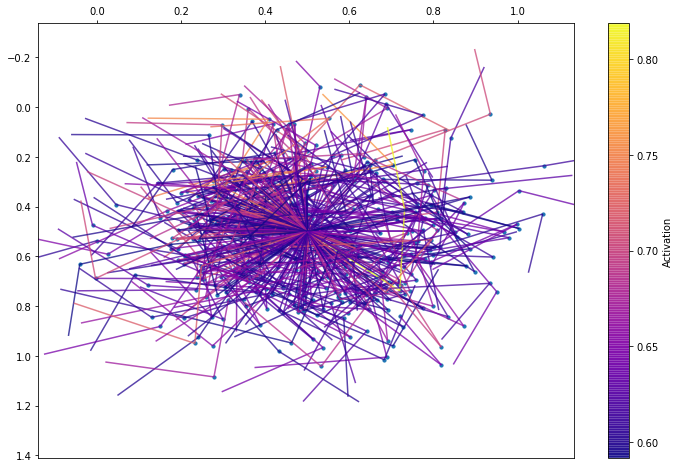

filter activations 0


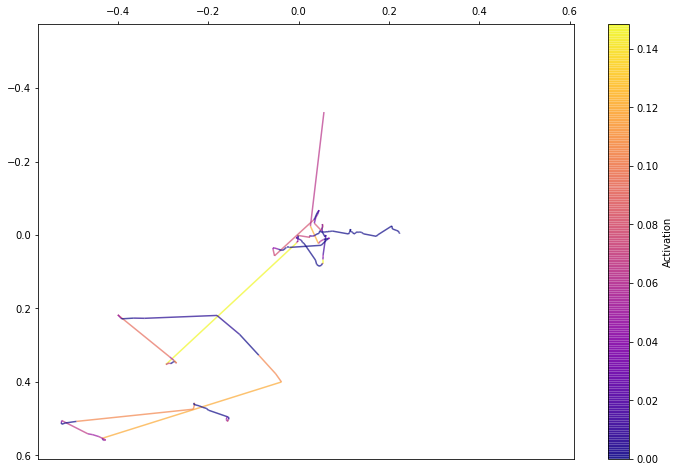

FILTER # 1
Filter:
 [[ 0.    0.29]
 [ 0.01  0.28]
 [-0.01  0.11]]
Activation threshold: 0.54


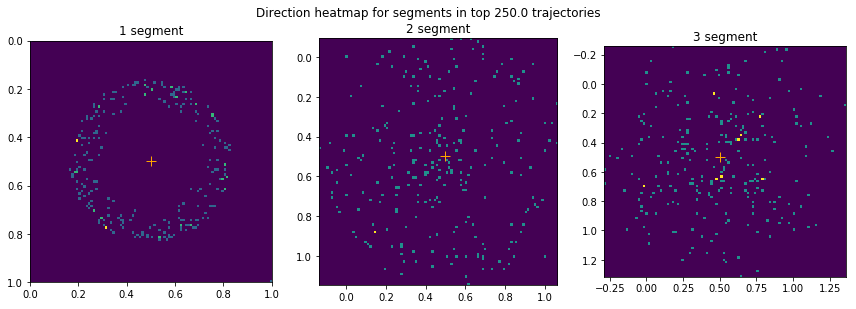

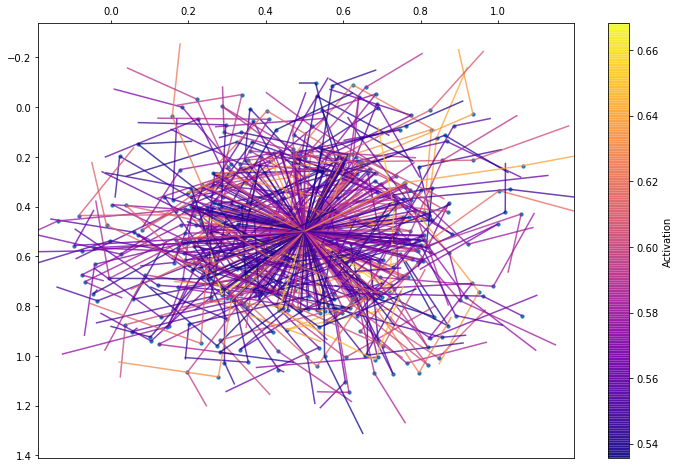

filter activations 1


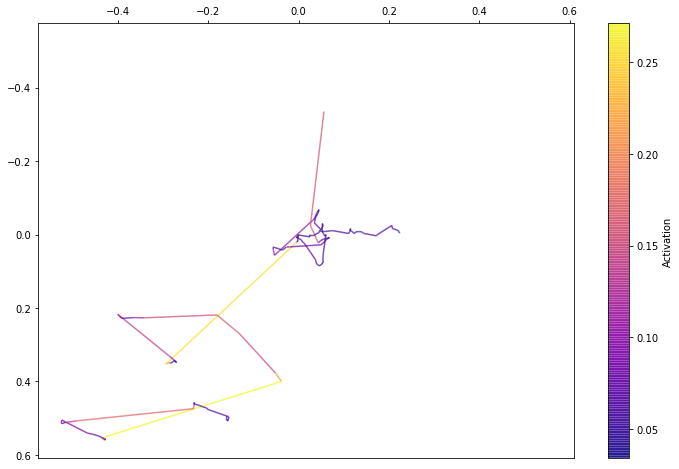

FILTER # 2
Filter:
 [[-0.06  0.32]
 [-0.42  0.14]
 [ 0.03 -0.01]]
Activation threshold: 0.27


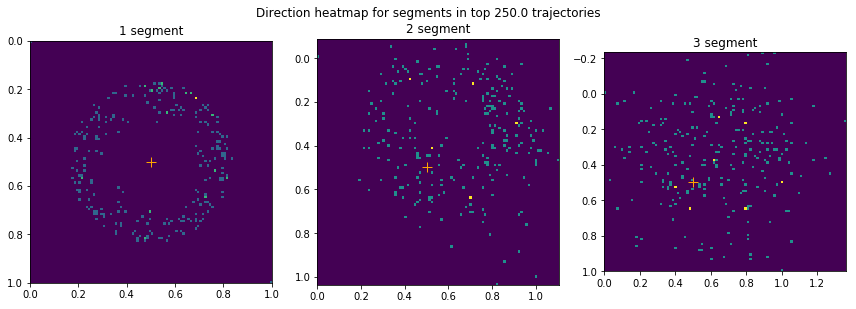

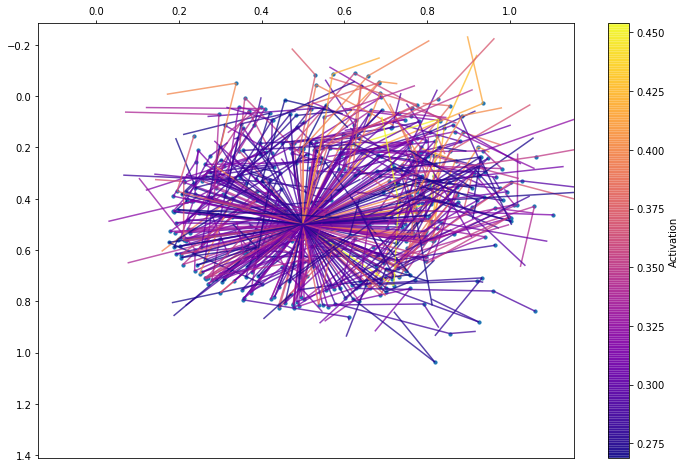

filter activations 2


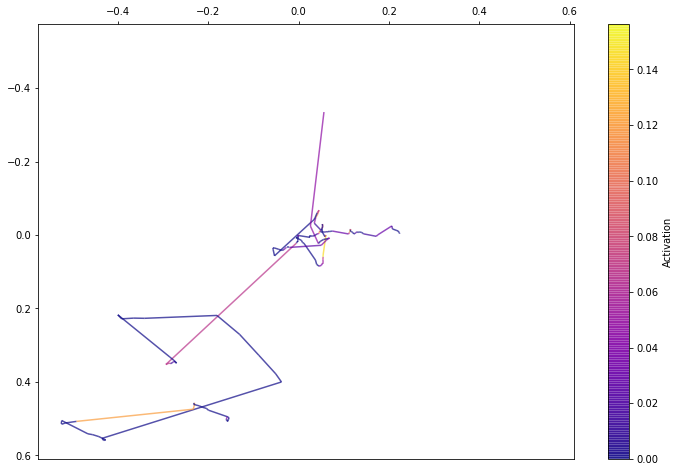

FILTER # 3
Filter:
 [[-0.21  0.02]
 [-0.12 -0.22]
 [-0.01 -0.04]]
Activation threshold: -0.13


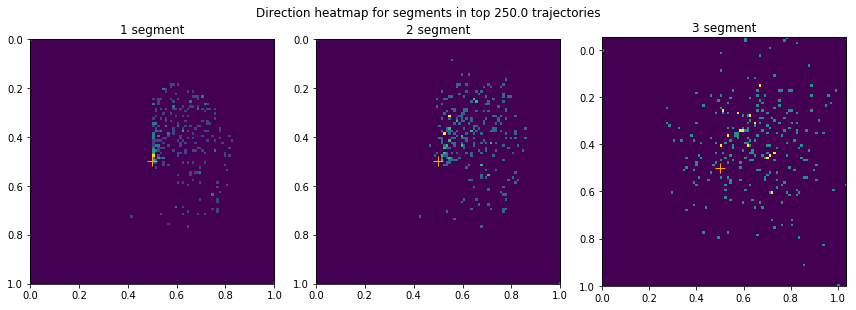

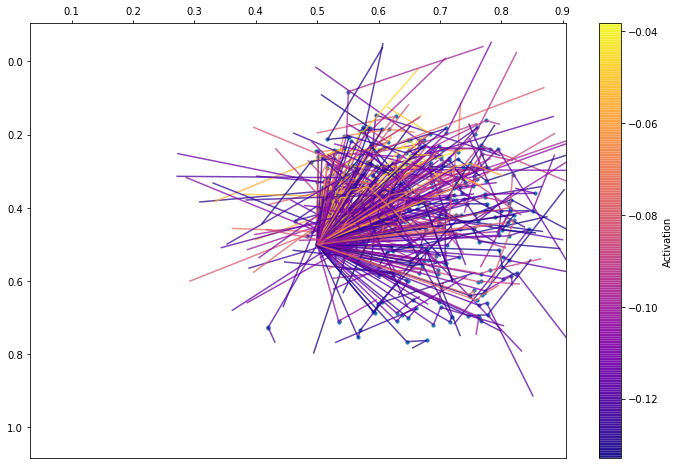

filter activations 3


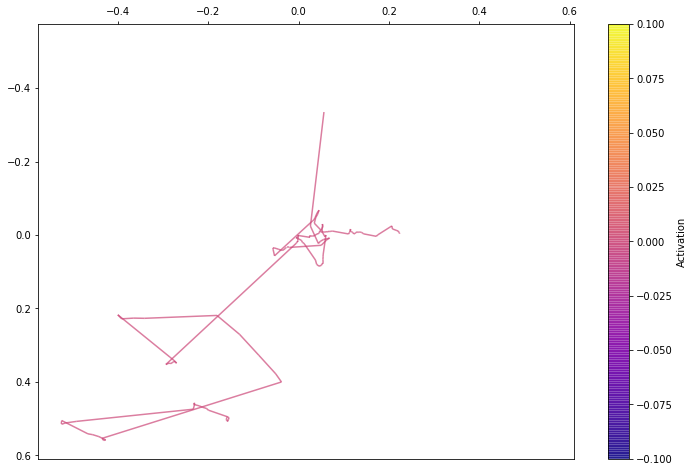

FILTER # 4
Filter:
 [[ 0.01  0.1 ]
 [-0.28 -0.25]
 [-0.17  0.37]]
Activation threshold: 0.15


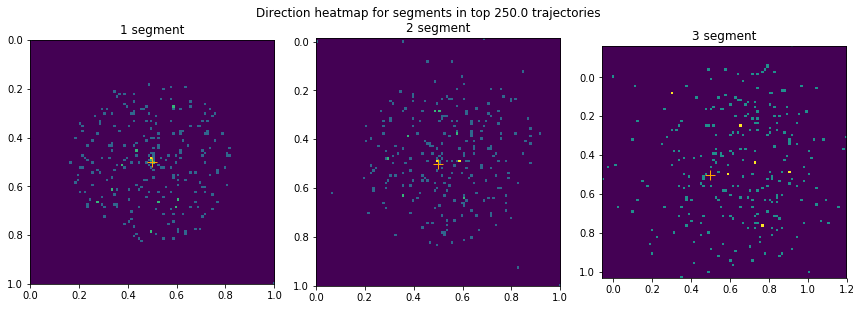

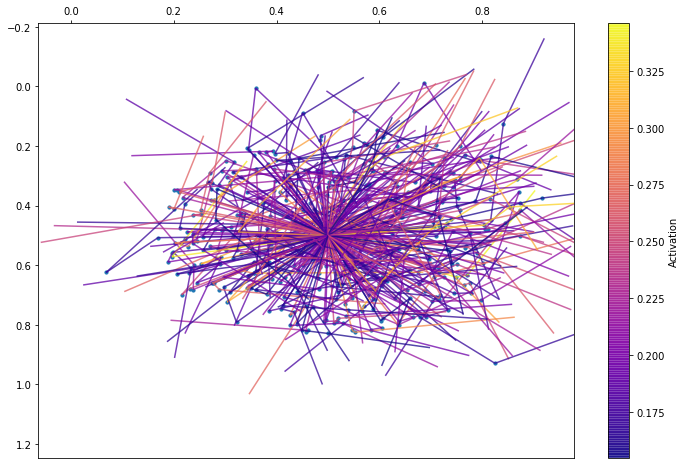

filter activations 4


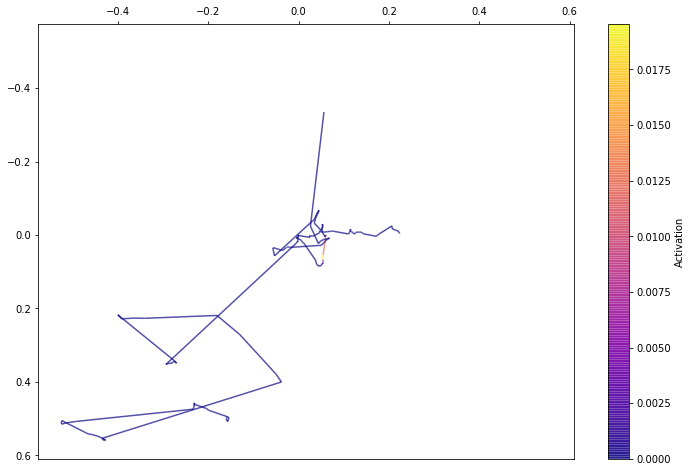

In [14]:
# Visualize filters and their activations on the input sequence
l = 'conv1'
num_obs = 3
shift = 0
num_filters = 5 #activations[l].shape[-1]
data = x_test #test_images

# get activations for the data
activations = get_activations(model, data, layers=[l])
for k, v in activations.items():
    print(k, v.shape)

# convert data observations into paths
lines = []
for i in range(num_obs):
    path = data[shift+i, ...]
    move_dir = denorm(path[:, 0], x_max=np.pi*2)
    move_len = denorm(path[:, 1], x_max=1.44)
    xy = traject_to_coord(move_dir, move_len)
    segments = list(zip(xy[:-1], xy[1:]))
    lines.append(segments)
lines = np.concatenate(lines)

# plot data 
p = plot_path(lines, feed_lines=True, screen_lims=False, title='Data', show_joints=True, clip=False)
plt.show()

# plot filters and their activations
for fn in range(num_filters):
    
    print("filter #".upper(), fn)
    fig1, fig2 = plot_conv1_filter(model, fn, n_obs=5000, show_percentile=True, percentile=99)
    fig1.savefig('imgs/conv1_{}_act_heatmap.png'.format(fn))
    fig2.savefig('imgs/conv1_{}_sim_data.png'.format(fn))
    plt.show(fig1)    
    plt.show(fig2)
    
    print("filter activations", fn)
    fw = np.concatenate([activations[l].squeeze()[i, :, fn] for i in range(num_obs)])
    if not np.all(fw == 0):
        fw = filter_act_to_input(fw, model, l, len(fw))
        
    fig3 = plot_path(lines, segments_weights=fw, figsize=(12, 8), 
                  change_width=False, clip=False, feed_lines=True, alpha=0.7)
    fig3.savefig('imgs/conv1_{}_act_on_data.png'.format(fn))
    plt.show(fig3)   